In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # HuggingFaceEmbedding
)
import json
import time 
# import HuggingFaceEmbedding
import matplotlib.pyplot as plt
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask


In [2]:
# model_name = "facebook/opt-1.3b"
model_name = "facebook/opt-125m"
local_dir="/data/models"

torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config,
    device_map=device_map,
    cache_dir = local_dir,
    pad_token_id=1,
    trust_remote_code = True
)

base_model.eval()

if "Qwen" in model_name:
    tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token='<|extra_0|>', trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side = 'right', truncation_side='right')
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# if "Llama-2" in model_name or "Mistral" in model_name:
#     # tokenizer.pad_token_id = tokenizer.bos_token_id
#     tokenizer.pad_token = tokenizer.bos_token
if tokenizer.pad_token_id == None:
    tokenizer.pad_token_id = 1

tokenizer.padding_side = "right"


/opt/conda/envs/mytorch/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
import datasets
from pathlib import Path
datasets.config.DOWNLOADED_DATASETS_PATH = Path("/home/ubuntu/data/.cache/huggingface")
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)

In [3]:
ex = """The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum. Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19. Police were called to the carriageway around 6.10am and the road was promptly closed in both directions. Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene. Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27). Tributes to the mum were left at the scene and on social media. Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt. "Be at peace dear Marta." A floral tribute left at the scene said goodbye to the "beautiful and kind soul". It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always. "Rest in peace Marta, Love from Lorraine, Colin and family." The inquest will take place at the Archbishop&apos;s Palace in Maidstone and will examine the circumstances surrounding Mrs Kendle&apos;s death. Are you struggling or know someone who is? Watch our video below to find out how the Samaritans could help. Mrs Kendle&apos;s death prompted the setting up of a petition calling for higher railings along the Gracious Lane bridge by Sevenoaks Common - to prevent people falling and to protect drivers from below. By today (February 25) 4,500 people had signed. The same site was the scene of another death in July last year when Southborough woman, Angela Skinner, 54, also died after falling on to the A21."""
# ex = "hello world"
# ex = "ABC is a startup based in New York City and Paris"
tokens = tokenizer(ex, return_tensors='pt')
input_ids = tokens.input_ids.to(device="cuda")
print(input_ids.shape)
seq_length = input_ids.size(1)
attention_mask = tokens.attention_mask.cuda()

input_embeds = base_model.model.decoder.embed_tokens(input_ids) 
# print(input_embeds.shape)

causal_attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, (1, seq_length),
            input_embeds, 0
            )

pos_embeds = base_model.model.decoder.embed_positions(attention_mask,0) 
# print(pos_embeds.shape)

# cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
# similiarity = []
activations = {}
pre_activations = {}
layer_outputs = {}
for idx in range(len(base_model.model.decoder.layers)):
    activations[f"{idx}"] = []
    pre_activations[f"{idx}"] = []
    layer_outputs[f"{idx}"] = []

with torch.no_grad():
    # x_old = input_embeds
    hidden_states = input_embeds + pos_embeds
    print(hidden_states.shape)
    # past_key_value = None
    # x = base_model.model.decoder(inputs_embeds = input_embeds)#, output_hidden_states=True)#,attention_mask=attention_mask)#[0]
    # print(x[0].shape)
    for idx, decoder in enumerate(base_model.model.decoder.layers):
        # hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
        residual = hidden_states
        hidden_states = decoder.self_attn_layer_norm(hidden_states)
        hidden_states, self_attn_weights, present_key_value = decoder.self_attn(hidden_states=hidden_states,
                                                                                attention_mask=causal_attention_mask)
        hidden_states = residual + hidden_states

        
        ## Fully Connected
        # print("pre mlp: ", hidden_states.shape)
        hidden_states_shape = hidden_states.shape
        hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))
        residual = hidden_states
        hidden_states = decoder.final_layer_norm(hidden_states)
        # hidden_states = decoder.mlp(hidden_states)
        
        hidden_states = decoder.fc1(hidden_states)
        # print("pre act: ", hidden_states.shape)
        pre_activations[f"{idx}"].append(hidden_states[-1,:].to(dtype = torch.float32, device = "cpu"))
        hidden_states = decoder.activation_fn(hidden_states)
        # print("act: ", hidden_states.shape)
        activations[f"{idx}"].append(hidden_states[-1,:].to(dtype = torch.float32, device = "cpu"))

        hidden_states = decoder.fc2(hidden_states)
        hidden_states = (residual + hidden_states).view(hidden_states_shape)
        # print("layer output: ", hidden_states.shape)
        layer_outputs[f"{idx}"].append(hidden_states.to(dtype = torch.float32, device = "cpu"))

        # hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
        # # similiarity.append(cos(x_new,x_old).cpu())
        # # x_old = x_new
    hidden_states = base_model.model.decoder.final_layer_norm(hidden_states)
    x = base_model.lm_head(hidden_states)
    # x = base_model.lm_head(x[0])
# print(x.shape)
# similiarity = torch.stack(similiarity).squeeze()
with torch.no_grad():
    y = base_model(input_ids).logits
print(torch.allclose(x.to(y),y))
# print(torch.norm(x.to(y)-y,dim=-1))


torch.Size([1, 378])
torch.Size([1, 378, 2048])
True


IndexError: list index out of range

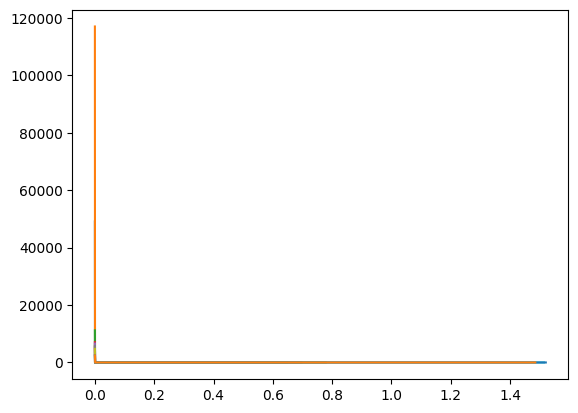

In [5]:
import numpy as np

def hist(x, num_bins, label):
    n, bin_edges = np.histogram(x, bins=num_bins)
    # n, bin_edges = np.histogram(N1, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'-',markersize=2,label=label)
    return bins_center

for idx in range(16):
    if idx == 0:
        num_bins = 10000
    elif idx == 1:
        num_bins = 40000
    else:
        num_bins = 4000
        
    x = activations[f"{idx}"][0].view(-1)
    hist(x,num_bins,f"{idx}")
# plt.xlim(-0.,0.002)
# y0 = -0.278
# plt.plot([y0,y0],[0,16],"k--")
plt.legend(handlelength=1)
plt.grid()

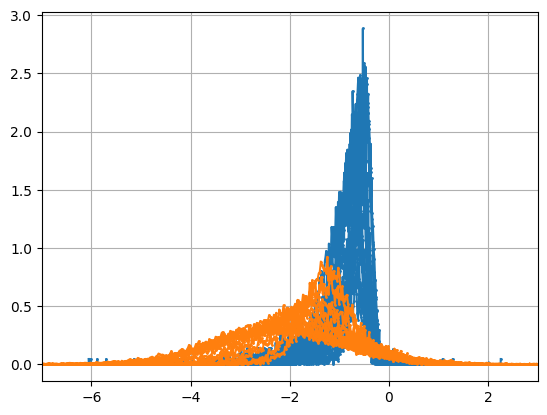

In [75]:
import numpy as np

def hist(x, num_bins, label, color = "C0"):
    n, bin_edges = np.histogram(x, bins=num_bins)
    # n, bin_edges = np.histogram(N1, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    # idx = np.argmax(n)
    # peak = bins_center[idx]
    peak = x.median()
    plt.plot(bins_center,n,'.-',markersize=2,color=color,label=label)
    return bins_center, peak

peak_values = []
for idx in range(0,32):
    if idx == 0:
        num_bins = 1000
    elif idx == 1:
        num_bins = 4000
    else:
        num_bins = 400
    
    x = pre_activations[f"{idx}"][0].view(-1)
    if idx< 16:    
        _, peak_val = hist(x,num_bins,f"{idx}")
    else:
        _, peak_val = hist(x,num_bins,f"{idx}","C1")
    peak_values.append(peak_val)

plt.xlim(-7,3)
# y0 = -0.278
# plt.plot([y0,y0],[0,16],"k--")
# plt.legend(handlelength=1)
plt.grid()

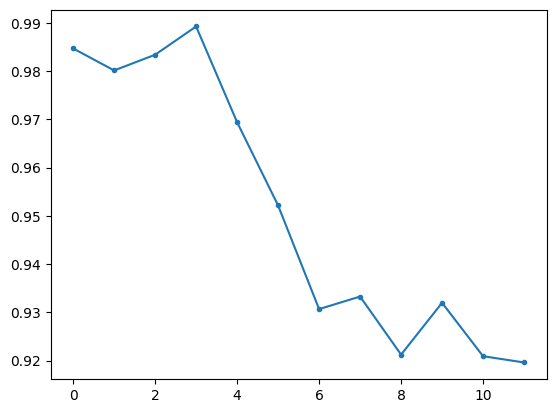

In [64]:
N_layers = len(pre_activations.keys())
negative_frac = np.zeros(N_layers)
for idx in range(N_layers):
    # x = np.sort(pre_activations[f"{idx}"][0].view(-1).numpy())
    # print(x.shape[0],np.argwhere(x>0)[0,0])
    # negative_frac[idx] = np.argwhere(x>0)[0,0]/x.shape[0]
    x = pre_activations[f"{idx}"][0].view(-1)
    negative_frac[idx] = torch.sum(x<0).item()/x.shape[0]
    # plt.plot(pre_activations[f"{idx}"][0].view(-1),".")
plt.plot(negative_frac,".-")
plt.show()

In [11]:
len(pre_activations.keys())

12

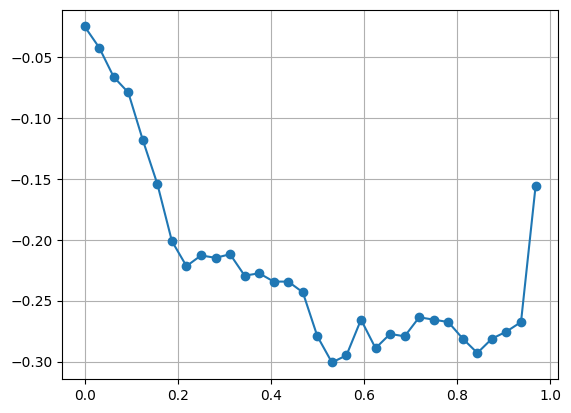

In [131]:
plt.plot(np.arange(32)/32, peak_values,"o-")
plt.grid()
plt.show()

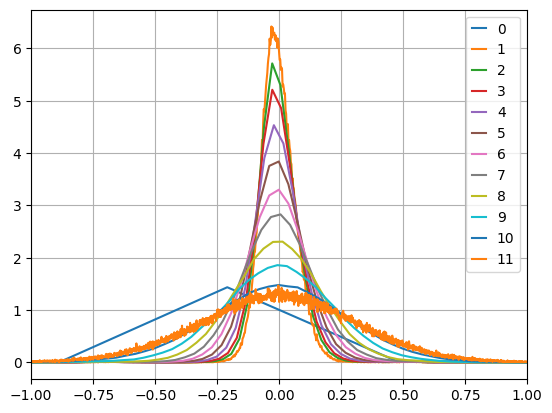

In [21]:
for idx in range(0,12):
    if idx == 0:
        num_bins = 200
    elif idx == 1:
        num_bins = 80000
    else:
        num_bins = 10000
        
    x = layer_outputs[f"{idx}"][0].view(-1)
    hist(x,num_bins,f"{idx}")
plt.xlim(-1,1)
plt.legend(handlelength=1)
plt.grid()

In [75]:
print(base_model)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

## multiple samples

In [53]:
from torch.utils.data import DataLoader
import datasets
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)


In [66]:
activations = {}
pre_activations = {}
layer_outputs = {}
for idx in range(len(base_model.model.decoder.layers)):
    activations[f"{idx}"] = []
    pre_activations[f"{idx}"] = []
    layer_outputs[f"{idx}"] = []

num_examples = 10
i = 0
for ex in dataset:
    i += 1
    if i % 10 == 0:
        print(i, end='\r')
    if i > num_examples:
        break
    
    tokens = tokenizer(ex['text'], return_tensors='pt')
    input_ids = tokens.input_ids.to(device="cuda")
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.cuda()

    input_embeds = base_model.model.decoder.embed_tokens(input_ids) 
    # print(input_embeds.shape)

    causal_attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, 0
                )

    pos_embeds = base_model.model.decoder.embed_positions(attention_mask,0) 
    # print(pos_embeds.shape)

    
    with torch.no_grad():
        hidden_states = input_embeds + pos_embeds

        for idx, decoder in enumerate(base_model.model.decoder.layers):
            # hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
            residual = hidden_states
            hidden_states = decoder.self_attn_layer_norm(hidden_states)
            hidden_states, self_attn_weights, present_key_value = decoder.self_attn(hidden_states=hidden_states,
                                                                                    attention_mask=causal_attention_mask)
            hidden_states = residual + hidden_states

            
            ## Fully Connected
            hidden_states_shape = hidden_states.shape
            hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))
            residual = hidden_states
            hidden_states = decoder.final_layer_norm(hidden_states)
            # hidden_states = decoder.mlp(hidden_states)
            
            hidden_states = decoder.fc1(hidden_states)
            # print("pre act: ", hidden_states.shape)
            pre_activations[f"{idx}"].append(hidden_states[-1,:].to(dtype = torch.float32, device = "cpu"))
            hidden_states = decoder.activation_fn(hidden_states)
            # print("act: ", hidden_states.shape)
            activations[f"{idx}"].append(hidden_states[-1,:].to(dtype = torch.float32, device = "cpu"))

            hidden_states = decoder.fc2(hidden_states)
            hidden_states = (residual + hidden_states).view(hidden_states_shape)
            # print("layer output: ", hidden_states.shape)
            layer_outputs[f"{idx}"].append(hidden_states.to(dtype = torch.float32, device = "cpu"))



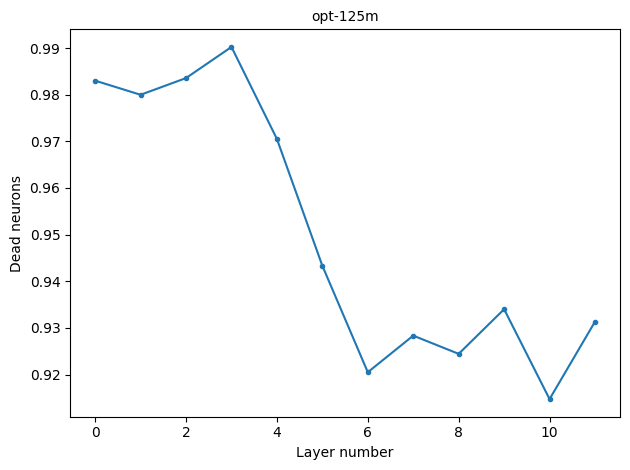

In [69]:
num_layers = len(pre_activations.keys())
negative_frac = np.zeros(num_layers)
for idx in range(num_layers):
    x = torch.cat(pre_activations[f"{idx}"], dim = 0)
    # print(x.shape)
    
    negative_frac[idx] = torch.sum(x<0).item()/x.shape[0]

plt.plot(negative_frac,".-")
plt.xlabel("Layer number")
plt.ylabel("Dead neurons")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

## parallelized

In [3]:
from torch.utils.data import DataLoader
import datasets
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)
# dataset = datasets.load_dataset('garage-bAInd/Open-Platypus', split='train', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    # prompts = [example['output'] for example in examples]
    return {'input': prompts}

BATCH_SIZE = 8
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [4]:
i = 0 
for batch in data_loader:
    i += 1
    if i == 51:
        break

for text in batch['input']:
    print(len(text.split(' ')))

963
230
8925
100


In [17]:
device = "cuda"
last_token_sim = []
num_batches = 40
i = 0 

activations = {}
pre_activations = {}
layer_outputs = {}
for idx in range(len(base_model.model.decoder.layers)):
    activations[f"{idx}"] = []
    pre_activations[f"{idx}"] = []
    layer_outputs[f"{idx}"] = []    

for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break
        
    tokens = tokenizer(batch['input'], padding='max_length', max_length = 1000, truncation=True, return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    ####
    input_embeds = base_model.model.decoder.embed_tokens(input_ids) 
    # print(input_embeds.shape)

    causal_attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (BATCH_SIZE, seq_length),
                input_embeds, 0
                )

    pos_embeds = base_model.model.decoder.embed_positions(attention_mask,0) 
    # print(pos_embeds.shape)
    
    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)

    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))

    similarity = []
    with torch.no_grad():
        hidden_states = input_embeds + pos_embeds
        # print(hidden_states)
        for idx, decoder in enumerate(base_model.model.decoder.layers):
            # hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
            residual = hidden_states
            hidden_states = decoder.self_attn_layer_norm(hidden_states)
            hidden_states, self_attn_weights, present_key_value = decoder.self_attn(hidden_states=hidden_states,
                                                                                    attention_mask=causal_attention_mask)
            hidden_states = residual + hidden_states
            
            ## Fully Connected
            hidden_states_shape = hidden_states.shape
            hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))
            residual = hidden_states
            hidden_states = decoder.final_layer_norm(hidden_states)
            # hidden_states = decoder.mlp(hidden_states)

            hidden_states = decoder.fc1(hidden_states)
            # print(hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:].shape)
            x = hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:]
            pre_activations[f"{idx}"].append(x.view(-1).to(dtype = torch.float32, device = "cpu"))
            hidden_states = decoder.activation_fn(hidden_states)
            x = hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:]
            activations[f"{idx}"].append(x.view(-1).to(dtype = torch.float32, device = "cpu"))

            hidden_states = decoder.fc2(hidden_states)
            hidden_states = (residual + hidden_states).view(hidden_states_shape)
            
            x = hidden_states[row_indices,last_token,:]
            layer_outputs[f"{idx}"].append(x.view(-1).to(dtype = torch.float32, device = "cpu"))


# print("last_token_sim:", last_token_sim.shape)



KeyboardInterrupt: 

In [14]:
pre_activations["1"][0].shape

torch.Size([81920])

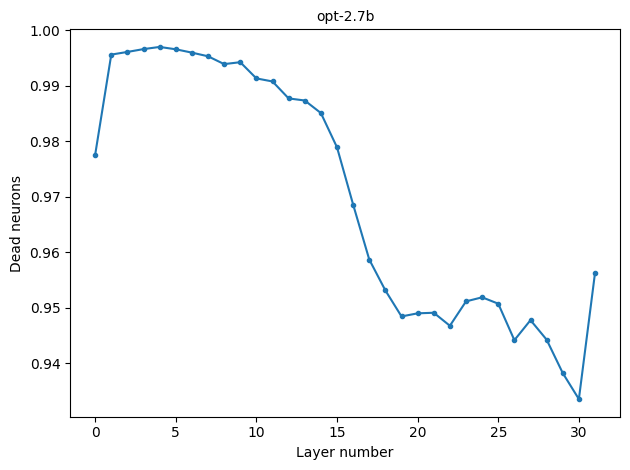

In [13]:
num_layers = len(pre_activations.keys())
negative_frac = torch.zeros(num_layers)
for idx in range(num_layers):
    x = torch.cat(pre_activations[f"{idx}"], dim = 0)    
    negative_frac[idx] = torch.sum(x<0).item()/x.shape[0]

plt.plot(negative_frac,".-")

plt.xlabel("Layer number")
plt.ylabel("Dead neurons")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

## cosine similarity

In [4]:
device = "cuda"
last_token_sim = []
num_batches = 40
i = 0 

for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break
        
    tokens = tokenizer(batch['input'], padding='max_length', max_length = 1000, truncation=True, return_tensors='pt')
    # tokens = tokenizer(batch['input'], padding=True, truncation=True, return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    ####
    input_embeds = base_model.model.decoder.embed_tokens(input_ids) 
    # print(input_embeds.shape)

    causal_attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, input_ids.size(),
                input_embeds, 0
                )

    pos_embeds = base_model.model.decoder.embed_positions(attention_mask,0) 
    # print(pos_embeds.shape)
    
    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)

    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    similarity = []
    with torch.no_grad():
        hidden_states = input_embeds + pos_embeds
        # print(hidden_states)
        for idx, decoder in enumerate(base_model.model.decoder.layers):
            x_old = hidden_states
            hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
            similarity.append(cos(hidden_states[row_indices,last_token,:].to(torch.float32),x_old[row_indices,last_token,:].to(torch.float32)).cpu())
        # hidden_states = base_model.model.decoder.final_layer_norm(hidden_states)
        # x = base_model.lm_head(hidden_states)
    similarity = torch.stack(similarity).squeeze()
    # print("sim:", similarity.shape)
    last_token_sim.append(similarity)
    # print(x.shape)
    # similiarity = torch.stack(similiarity).squeeze()
    # with torch.no_grad():
    #     y = base_model(input_ids).logits
    # print(torch.allclose(x[row_indices,last_token,:].to(y),y[row_indices,last_token,:]))
    # # print(torch.functional.norm(x[row_indices,last_token,:].to(y)-y[row_indices,last_token,:]).item())
    # print(f"{''.join(['-']*10)}")

last_token_sim = torch.cat(last_token_sim, dim = 1)
print("last_token_sim:", last_token_sim.shape)



last_token_sim: torch.Size([12, 320])


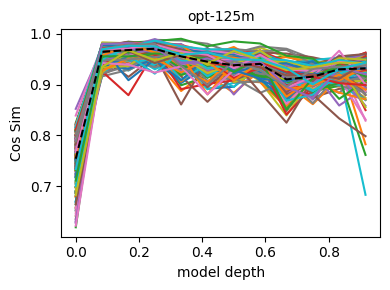

In [6]:
num_layers = len(base_model.model.decoder.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim)
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

In [8]:
last_token_sim[1:,:].mean(dim=(0,1)).item()

0.9694796800613403

In [5]:
last_token_sim[1:,:].mean(dim=(0,1)).item()

0.942709743976593

## similarity of consecutive activations

In [8]:
device = "cuda"
last_token_sim = []
num_batches = 40
i = 0 
 

for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break
        
    tokens = tokenizer(batch['input'], padding='max_length', max_length = 1000, truncation=True, return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    ####
    input_embeds = base_model.model.decoder.embed_tokens(input_ids) 
    # print(input_embeds.shape)

    causal_attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (BATCH_SIZE, seq_length),
                input_embeds, 0
                )

    pos_embeds = base_model.model.decoder.embed_positions(attention_mask,0) 
    # print(pos_embeds.shape)
    
    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)

    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))

    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    similarity = []
    with torch.no_grad():
        hidden_states = input_embeds + pos_embeds
        # print(hidden_states)
        for idx, decoder in enumerate(base_model.model.decoder.layers):
            # hidden_states = decoder(hidden_states,attention_mask=causal_attention_mask)[0]
            residual = hidden_states
            hidden_states = decoder.self_attn_layer_norm(hidden_states)
            hidden_states, self_attn_weights, present_key_value = decoder.self_attn(hidden_states=hidden_states,
                                                                                    attention_mask=causal_attention_mask)
            hidden_states = residual + hidden_states
            
            ## Fully Connected
            hidden_states_shape = hidden_states.shape
            hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))
            residual = hidden_states
            hidden_states = decoder.final_layer_norm(hidden_states)
            # hidden_states = decoder.mlp(hidden_states)

            hidden_states = decoder.fc1(hidden_states)
            # print(hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:].shape)
            hidden_states = decoder.activation_fn(hidden_states)
            if idx == 0:
                x_old = hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:]
            else:
                x_new = hidden_states.view(BATCH_SIZE, hidden_states_shape[1], -1)[row_indices,last_token,:]
                similarity.append(cos(x_new.to(torch.float32),x_old.to(torch.float32)).cpu())
                x_old = x_new
                
            hidden_states = decoder.fc2(hidden_states)
            hidden_states = (residual + hidden_states).view(hidden_states_shape)
            
    similarity = torch.stack(similarity).squeeze()
    last_token_sim.append(similarity)


last_token_sim = torch.cat(last_token_sim, dim = 1)
print("last_token_sim:", last_token_sim.shape)



last_token_sim: torch.Size([11, 320])


In [9]:
last_token_sim[:,:].mean(dim=(0,1)).item()

0.024600384756922722

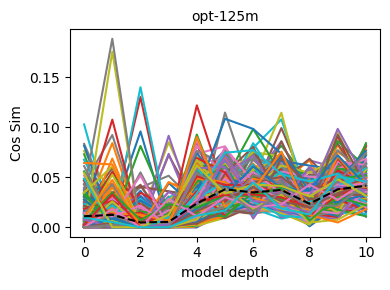

In [11]:
num_layers = len(base_model.model.decoder.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers-1), last_token_sim)
plt.plot(torch.arange(num_layers-1), last_token_sim.mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()